In [3]:
import numpy as np
from typing import List
from tqdm import tqdm
import jax.numpy as jnp

from solver import pde_solution
from kl_extension import KLExpansion
from utils import get_d_from_u
import jax

In [4]:
points = [(50, 48), (32, 25), (10, 48)]

kl = KLExpansion(grid=(64, 64))
kl.calculate_eigh()

In [5]:
import matplotlib.pyplot as plt

In [6]:
import os
import time
import numpy as np
from tqdm import tqdm
import jax
import jax.numpy as jnp
from jax import random
import optax
from flax import linen as nn
from flax.training import train_state

import pickle
from scipy.integrate import solve_ivp

class MLP(nn.Module):
    dim: int
    out_dim: int = 1
    w: int = 128

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(self.w)(x)
        x = nn.selu(x)
        x = nn.Dense(self.w)(x)
        x = nn.selu(x)
        x = nn.Dense(self.w)(x)
        x = nn.selu(x)
        x = nn.Dense(self.out_dim)(x)
        return x
    
model = MLP(dim=22, out_dim=16)

@jax.jit
def predict(params, inputs):
    return model.apply({"params": params}, inputs)

savedir = "models/epoch200k"
with open(f'{savedir}/w.pkl', 'rb') as f:
    params = pickle.load(f)

In [7]:
def ode_function(t, m, d, e):
    m = m.reshape(1, -1)
    t = jnp.array(t).reshape(1,-1)
    inputs = jnp.concatenate([m, d, e, t], axis=1)
    return predict(params, inputs)[0]

In [9]:
datadir = "data/point3_100k"

idx = 4

m, e = np.load(f'{datadir}/m.npy')[idx], np.load(f'{datadir}/e.npy')[idx]
d = np.load(f'{datadir}/d_5048_3225_1048.npy')[idx]


In [10]:
log_kappa = kl.expansion(m)
u = pde_solution(log_kappa, e)
d = get_d_from_u(u, points)

key = jax.random.PRNGKey(0)
m0 = jax.random.normal(key, (1, 16)) 
e = jnp.array(e).reshape(1,-1)
d = jnp.array(d).reshape(1,-1)
solution = solve_ivp(ode_function, t_span=[0, 1], y0=m0[0], t_eval=None, args=(d, e))
log_kappa_pred = kl.expansion(solution.y[:, -1])
u_pred = pde_solution(log_kappa_pred, e[0])

9.993801458956092e-07


2024-11-02 14:10:48.761481: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.1 which is older than the ptxas CUDA version (12.6.77). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


1.2786029799950277e-05


In [11]:
### d = get_d_from_u(u, points)
d_pred = get_d_from_u(u_pred, points)

In [12]:
d

Array([[-0.358923 ,  0.1720753,  0.5286995]], dtype=float32)

In [13]:
d_pred

array([-0.0910272 ,  0.02671197,  0.30040024])

In [14]:
u.mean(), u.std()

(0.13193160251712577, 0.4643811407724152)

In [15]:
u_pred.mean(), u_pred.std()

(0.03133356548180515, 0.2764290846063492)

IndexError: tuple index out of range

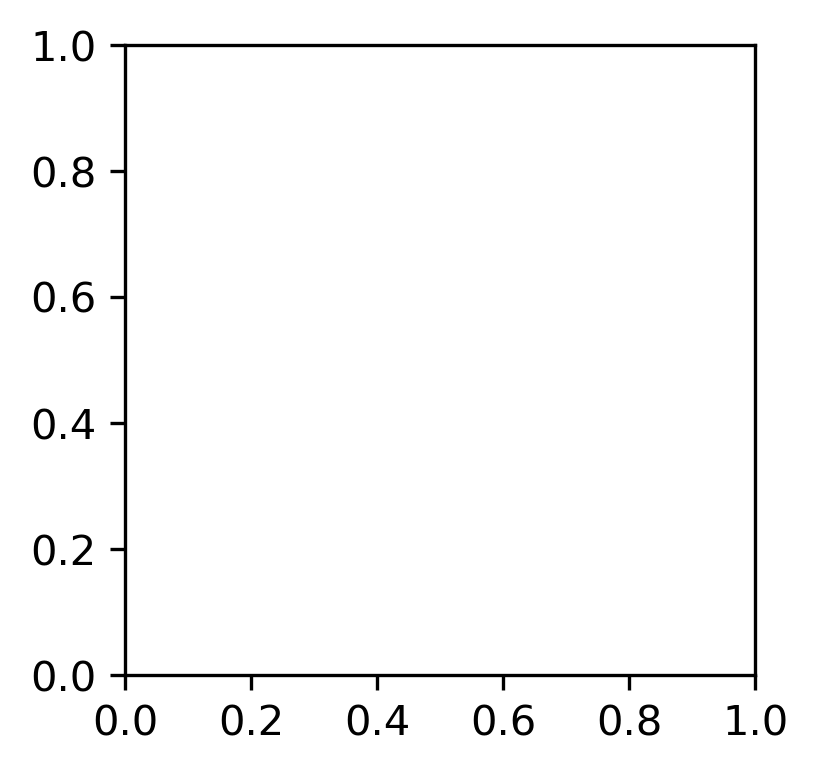

In [17]:
plt.figure(figsize=(6,6), dpi=300)
plt.subplot(221)
plt.imshow(log_kappa.T, cmap='viridis', origin='upper')
plt.title(fr'$\kappa$ true')
plt.subplot(222)
plt.imshow(u.T, cmap='viridis', origin='lower', extent=(0,0))
plt.scatter([x[1] for x in points], [x[0] for x in points], color='r', marker='*')
plt.title(fr'$u$ true')
plt.subplot(223)
plt.imshow(log_kappa_pred.T, cmap='viridis', origin='lower', extent=(0,0))
plt.title(fr'$\kappa$ pred')
plt.subplot(224)
plt.imshow(u_pred.T, cmap='viridis', origin='lower', extent=(0,0))
plt.scatter([x[1] for x in points], [x[0] for x in points], color='r', marker='*')
plt.title(fr'$u$ pred')
plt.savefig('imgs/pde_prediction_32.png')
plt.show()

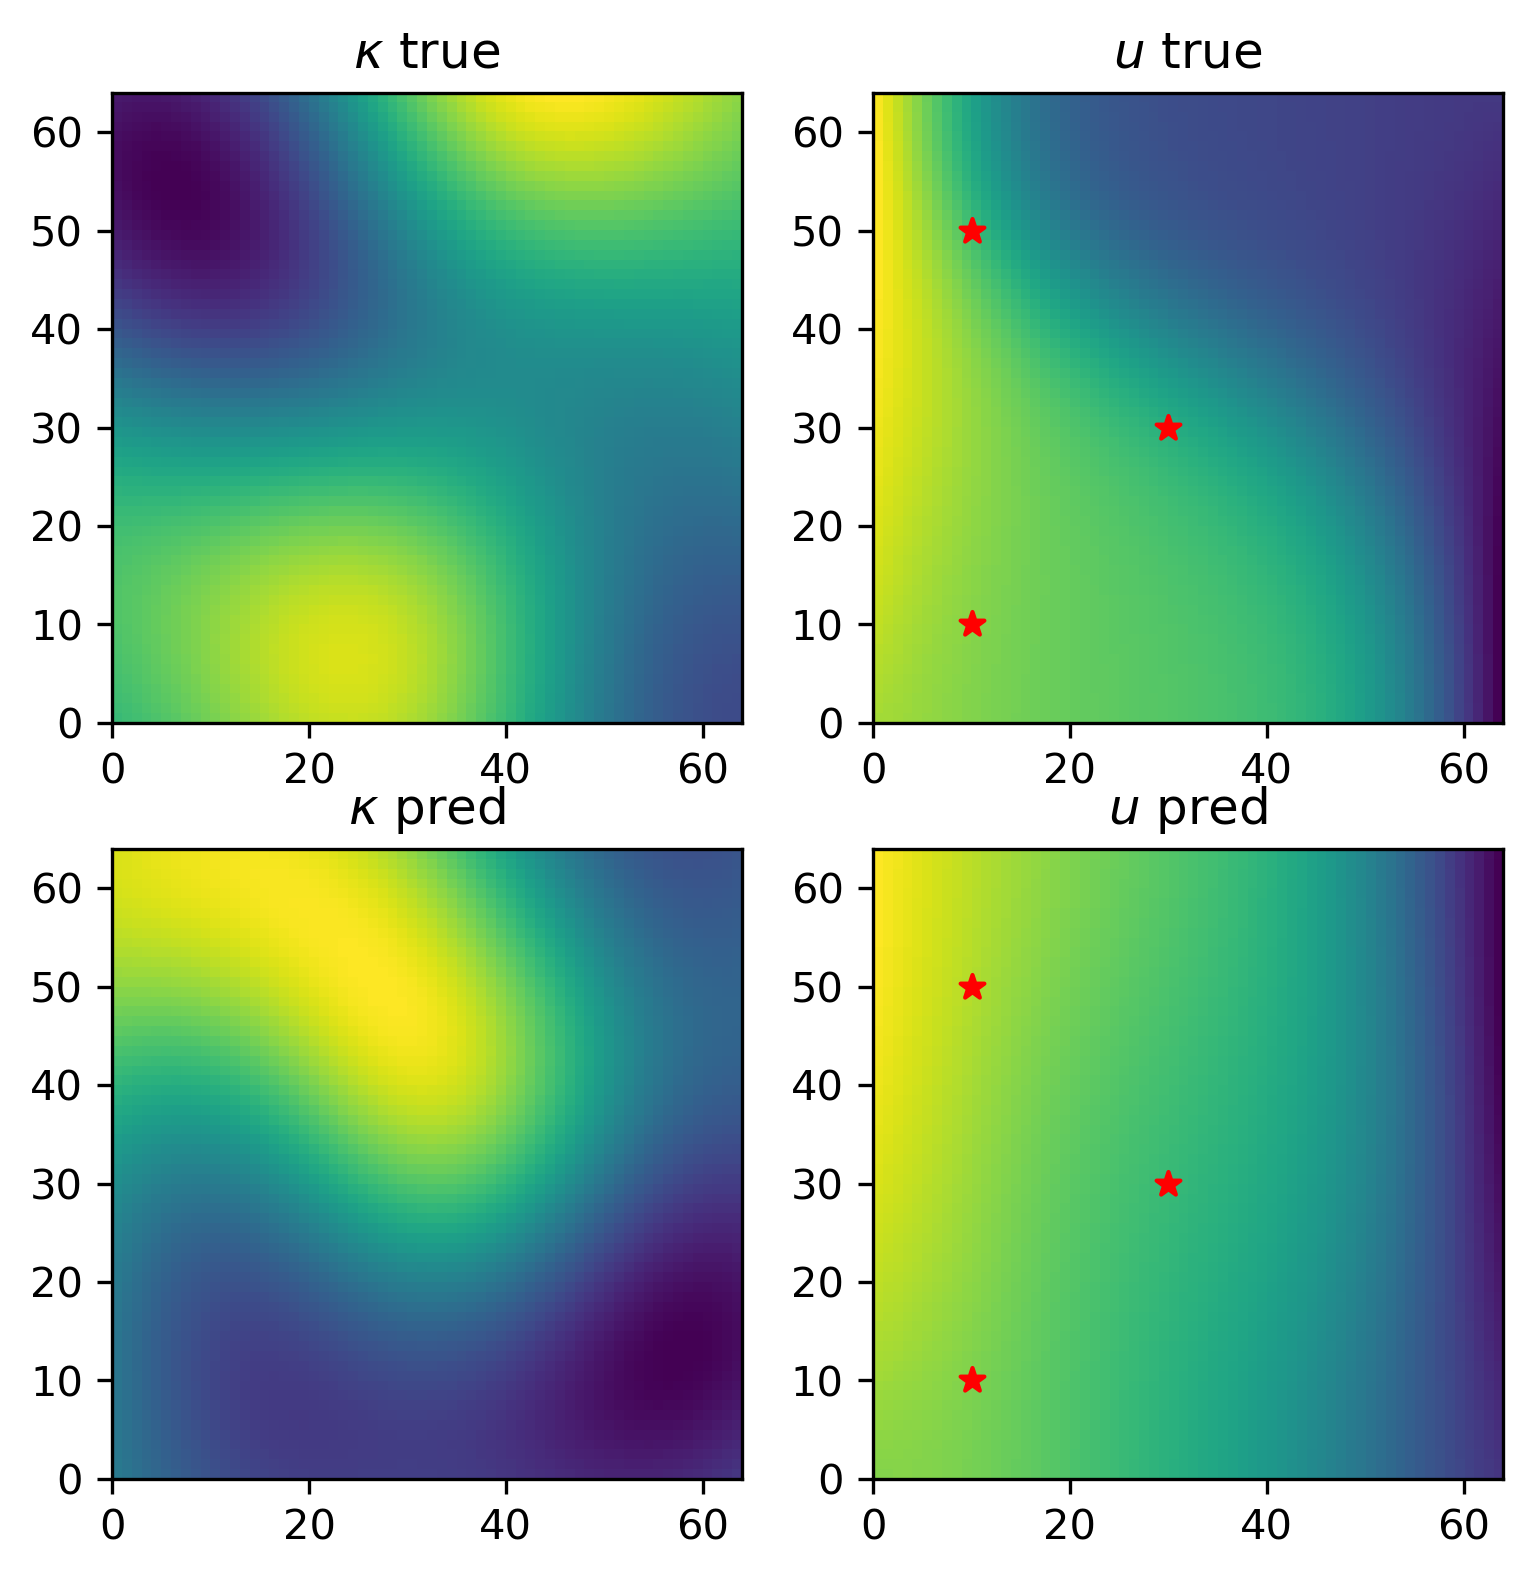

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6), dpi=300)

# Subplot 1: True Kappass
plt.subplot(221)
plt.imshow(log_kappa.T, cmap='viridis', origin='upper', extent=[0, log_kappa.shape[1], 0, log_kappa.shape[0]])
plt.title(fr'$\kappa$ true')

# Subplot 2: True u
plt.subplot(222)
plt.imshow(u.T, cmap='viridis', origin='upper', extent=[0, u.shape[1], 0, u.shape[0]])
plt.scatter([x[1] for x in points], [x[0] for x in points], color='r', marker='*')
plt.title(fr'$u$ true')

# Subplot 3: Predicted Kappa
plt.subplot(223)
plt.imshow(log_kappa_pred.T, cmap='viridis', origin='upper', extent=[0, log_kappa_pred.shape[1], 0, log_kappa_pred.shape[0]])
plt.title(fr'$\kappa$ pred')

# Subplot 4: Predicted u
plt.subplot(224)
plt.imshow(u_pred.T, cmap='viridis', origin='upper', extent=[0, u_pred.shape[1], 0, u_pred.shape[0]])
plt.scatter([x[1] for x in points], [x[0] for x in points], color='r', marker='*')
plt.title(fr'$u$ pred')

plt.savefig('imgs/pde_prediction_3.png')
plt.show()

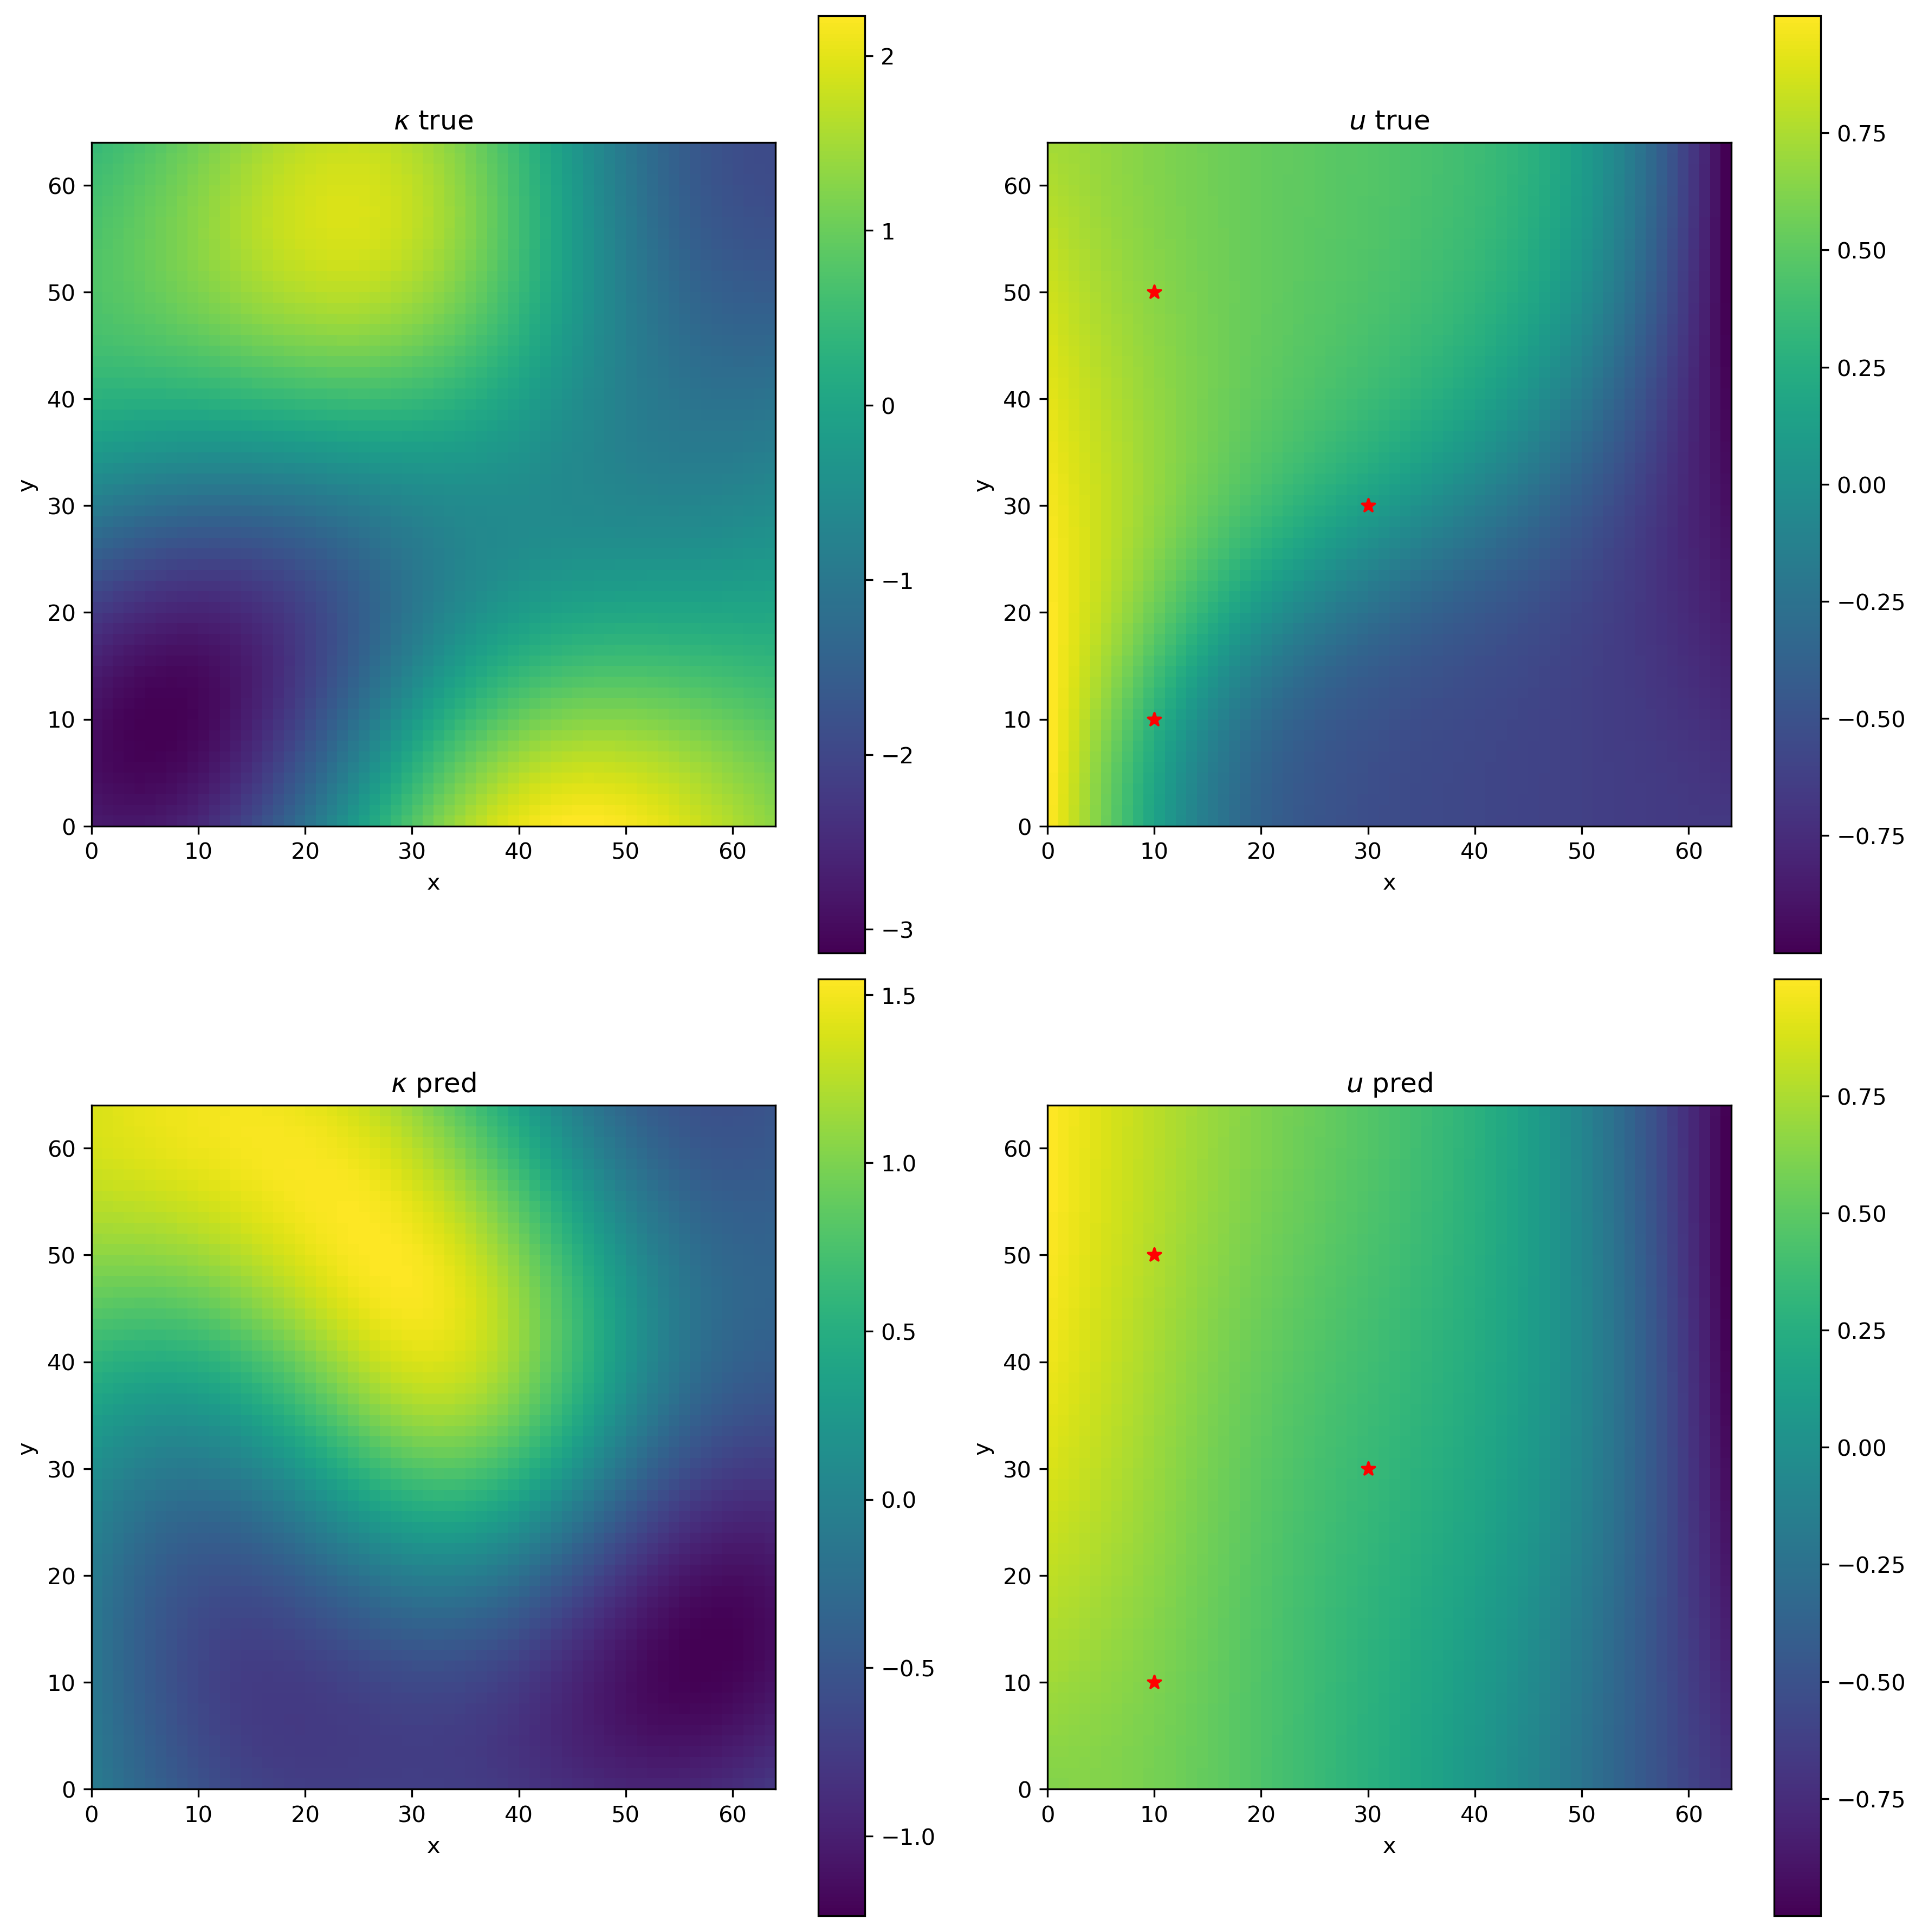

In [37]:
# Create a figure with 4 subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 12), dpi=300)

# Get the shape of the arrays
height, width = log_kappa.shape

# Plot kappa true
im1 = axs[0, 0].imshow(log_kappa.T, cmap='viridis', origin='lower', extent=(0, width, 0, height))
axs[0, 0].set_title(fr'$\kappa$ true')
axs[0, 0].set_xlabel('x')
axs[0, 0].set_ylabel('y')
fig.colorbar(im1, ax=axs[0, 0])  # Add a colorbar

# Plot u true
im2 = axs[0, 1].imshow(u.T, cmap='viridis', origin='lower', extent=(0, width, 0, height))
axs[0, 1].scatter([x[1] for x in points], [x[0] for x in points], color='r', marker='*')
axs[0, 1].set_title(fr'$u$ true')
axs[0, 1].set_xlabel('x')
axs[0, 1].set_ylabel('y')
fig.colorbar(im2, ax=axs[0, 1])  # Add a colorbar

# Plot kappa pred
im3 = axs[1, 0].imshow(log_kappa_pred.T, cmap='viridis', origin='upper', extent=(0, width, 0, height))
axs[1, 0].set_title(fr'$\kappa$ pred')
axs[1, 0].set_xlabel('x')
axs[1, 0].set_ylabel('y')
fig.colorbar(im3, ax=axs[1, 0])  # Add a colorbar

# Plot u pred
im4 = axs[1, 1].imshow(u_pred.T, cmap='viridis', origin='upper', extent=(0, width, 0, height))
axs[1, 1].scatter([x[1] for x in points], [x[0] for x in points], color='r', marker='*')
axs[1, 1].set_title(fr'$u$ pred')
axs[1, 1].set_xlabel('x')
axs[1, 1].set_ylabel('y')
fig.colorbar(im4, ax=axs[1, 1])  # Add a colorbar

# Layout so plots do not overlap
fig.tight_layout()

plt.savefig('imgs/pde_prediction_3.png')
plt.show()

# points = [(10, 10), (30, 30), (50, 10)]

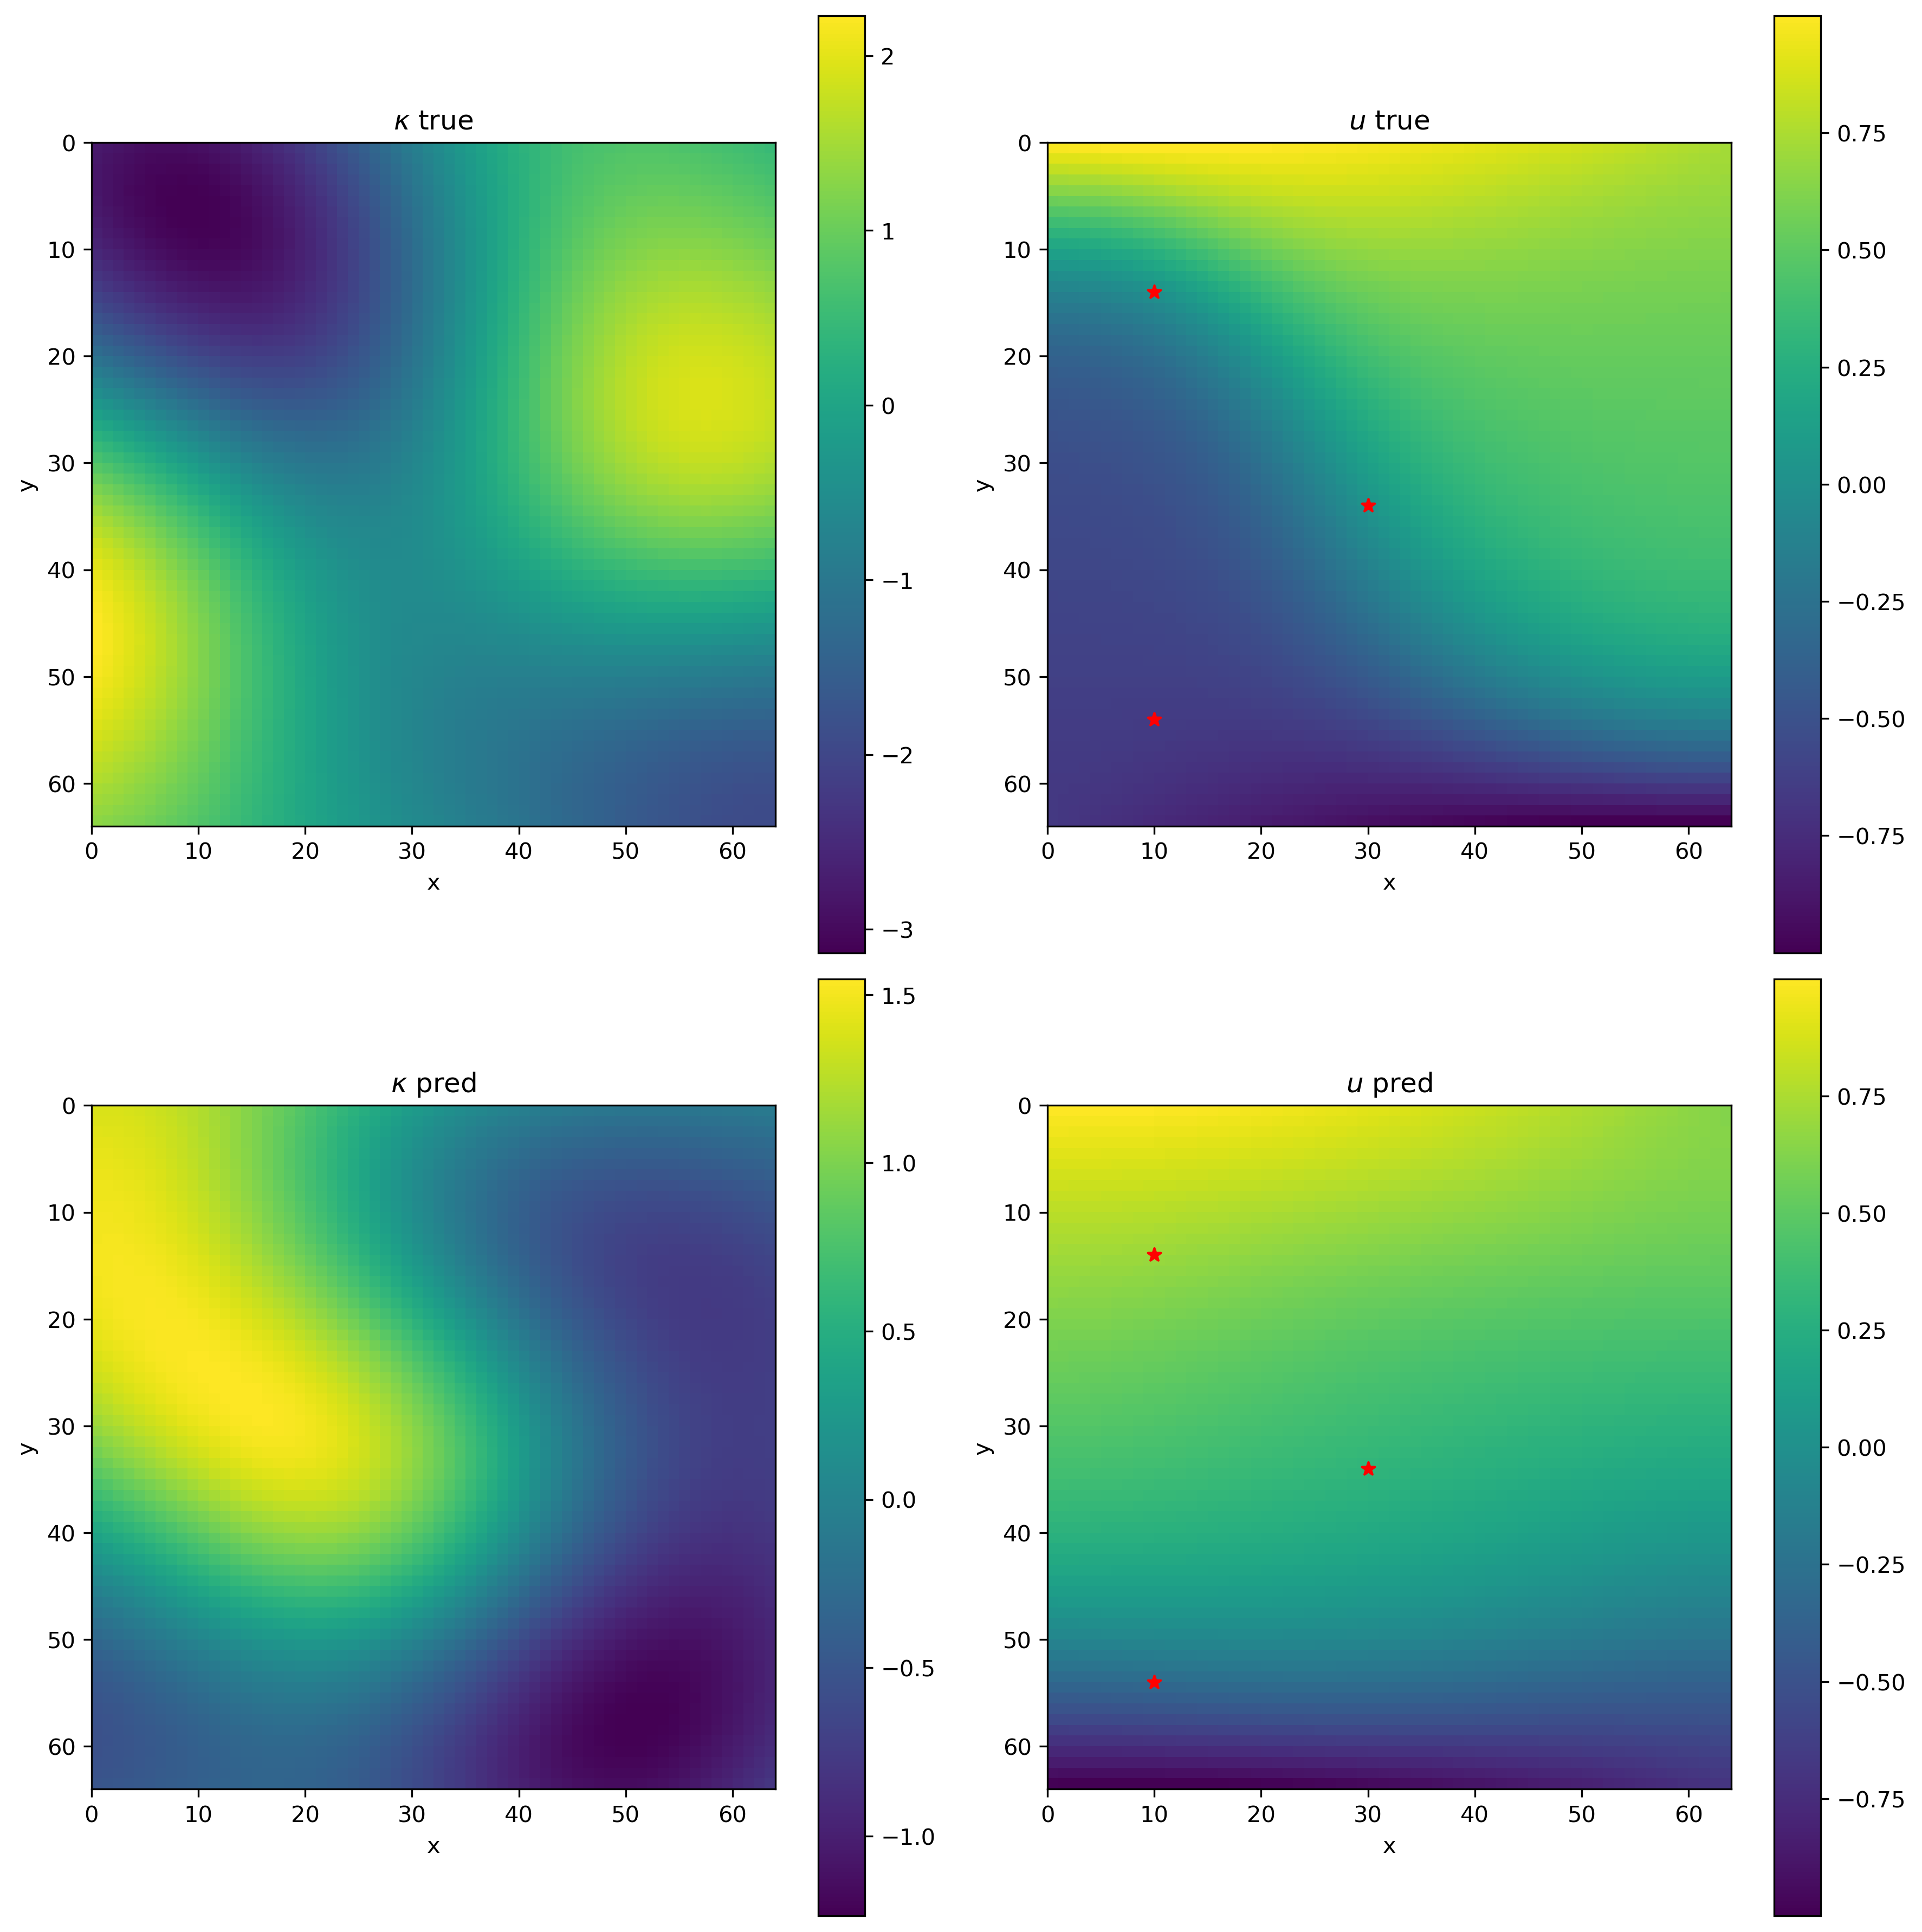

In [41]:
# Create a figure with 4 subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 12), dpi=300)

# Get the shape of the arrays
height, width = log_kappa.shape

# Plot kappa true
im1 = axs[0, 0].imshow(log_kappa, cmap='viridis', origin='upper', extent=(0, width, height, 0))
axs[0, 0].set_title(fr'$\kappa$ true')
axs[0, 0].set_xlabel('x')
axs[0, 0].set_ylabel('y')
fig.colorbar(im1, ax=axs[0, 0])  # Add a colorbar

# Plot u true
im2 = axs[0, 1].imshow(u, cmap='viridis', origin='upper', extent=(0, width, height, 0))
axs[0, 1].scatter([x[1] for x in points], [height - x[0] for x in points], color='r', marker='*')
axs[0, 1].set_title(fr'$u$ true')
axs[0, 1].set_xlabel('x')
axs[0, 1].set_ylabel('y')
fig.colorbar(im2, ax=axs[0, 1])  # Add a colorbar

# Plot kappa pred
im3 = axs[1, 0].imshow(log_kappa_pred, cmap='viridis', origin='upper', extent=(0, width, height, 0))
axs[1, 0].set_title(fr'$\kappa$ pred')
axs[1, 0].set_xlabel('x')
axs[1, 0].set_ylabel('y')
fig.colorbar(im3, ax=axs[1, 0])  # Add a colorbar

# Plot u pred
im4 = axs[1, 1].imshow(u_pred, cmap='viridis', origin='upper', extent=(0, width, height, 0))
axs[1, 1].scatter([x[1] for x in points], [height - x[0] for x in points], color='r', marker='*')
axs[1, 1].set_title(fr'$u$ pred')
axs[1, 1].set_xlabel('x')
axs[1, 1].set_ylabel('y')
fig.colorbar(im4, ax=axs[1, 1])  # Add a colorbar

# Layout so plots do not overlap
fig.tight_layout()

plt.savefig('imgs/pde_prediction_3.png')
plt.show()

In [42]:
m = np.random.normal(size = 16)

In [43]:
print(m)
log_kappa = kl.expansion(m)

[-1.39242814  0.47744533 -0.09078372 -0.74799097  0.1654612   0.32131234
 -0.18614115 -0.52609084 -2.26828243 -1.10712798 -0.92184901 -1.5179943
  1.88264721 -2.21450598  0.75220438 -0.50899429]


In [18]:
errors = []
sols = []

for i in tqdm(range(100)):
    key, batch_key = jax.random.split(key)
    m0 = jax.random.normal(batch_key, (1, 16)) 
    e = np.array([0.2, 0.9])
    u = pde_solution(log_kappa, (e[0], e[1]), verbose=False)
    d = get_d_from_u(u, points)
    m = jnp.array(m).reshape(1,-1)
    e = jnp.array(e).reshape(1,-1)
    d = jnp.array(d).reshape(1,-1)
    solution = solve_ivp(ode_function, t_span=[0, 1], y0=m0[0], t_eval=None, args=(d, e))
    log_kappa = kl.expansion(solution.y[:, -1])
    u = pde_solution(log_kappa, e[0], verbose=False)
    d_pred = get_d_from_u(u, points)
    sols.append(solution.y[:, -1])
    try:
        errors.append(np.linalg.norm(d - d_pred) / np.linalg.norm(d))
    except ValueError:
        pass


print(np.mean(errors), np.std(errors))

100%|█████████████████████████████████████████| 100/100 [01:17<00:00,  1.30it/s]

0.04576027 0.037112657


In [19]:
print(np.mean(errors), np.std(errors))

0.04576027 0.037112657


In [20]:
m_avg = np.mean(sols, axis=0)

In [21]:
print(m_avg.shape, '\n', m_avg)

(16,) 
 [-0.13742362  0.1667125  -1.82927641 -3.48144919  1.90013925  0.30038712
 -1.61946122 -0.27752941  0.98630732  0.18184533 -0.17317013  0.75027231
  1.07244418 -0.18718688  0.06467818  0.14673474]


In [22]:
m.dtype

dtype('float32')

In [23]:
m_avg.dtype

dtype('float64')

In [24]:
np.save('research_params_m.npy', m)
np.save('research_params_m_avg.npy', m_avg)

In [25]:
e.shape

(1, 2)

In [26]:
errors.index(min(errors))

26

In [27]:
errors[94]

0.07515559

In [28]:
m

Array([[ 0.57648057, -0.14009914, -0.9680301 , -0.22451487,  0.01257274,
        -0.09951536,  0.31391245, -0.07554463, -0.1934775 ,  1.5492172 ,
         1.6843405 , -0.2431769 , -0.9909729 ,  0.67386216, -1.4348806 ,
         0.28942645]], dtype=float32)

In [141]:
sols[94]

array([-0.69657578, -0.96396932, -1.39341539, -3.76611077,  1.39389781,
        1.47783997, -1.15466219, -1.23557856, -0.68666468,  0.29146659,
        0.91666167,  1.04431371,  2.44760461, -1.75721667,  0.54604033,
       -0.47896718])

In [142]:
log_kappa = kl.expansion(m[0])
u = pde_solution(log_kappa, e[0])
d = get_d_from_u(u, points)
log_kappa_pred = kl.expansion(sols[94])
u_pred = pde_solution(log_kappa_pred, e[0])

9.987328732215993e-07
9.96182561903966e-07


In [137]:
m_avg

array([ 0.26415926,  0.62311737, -2.01332945, -3.04821666,  2.08505172,
       -0.20806701, -1.03967325, -0.21595612,  0.97135849,  0.31277878,
       -0.04170439,  0.83932626,  0.9473387 , -0.21313074, -0.04923631,
        0.25302159])

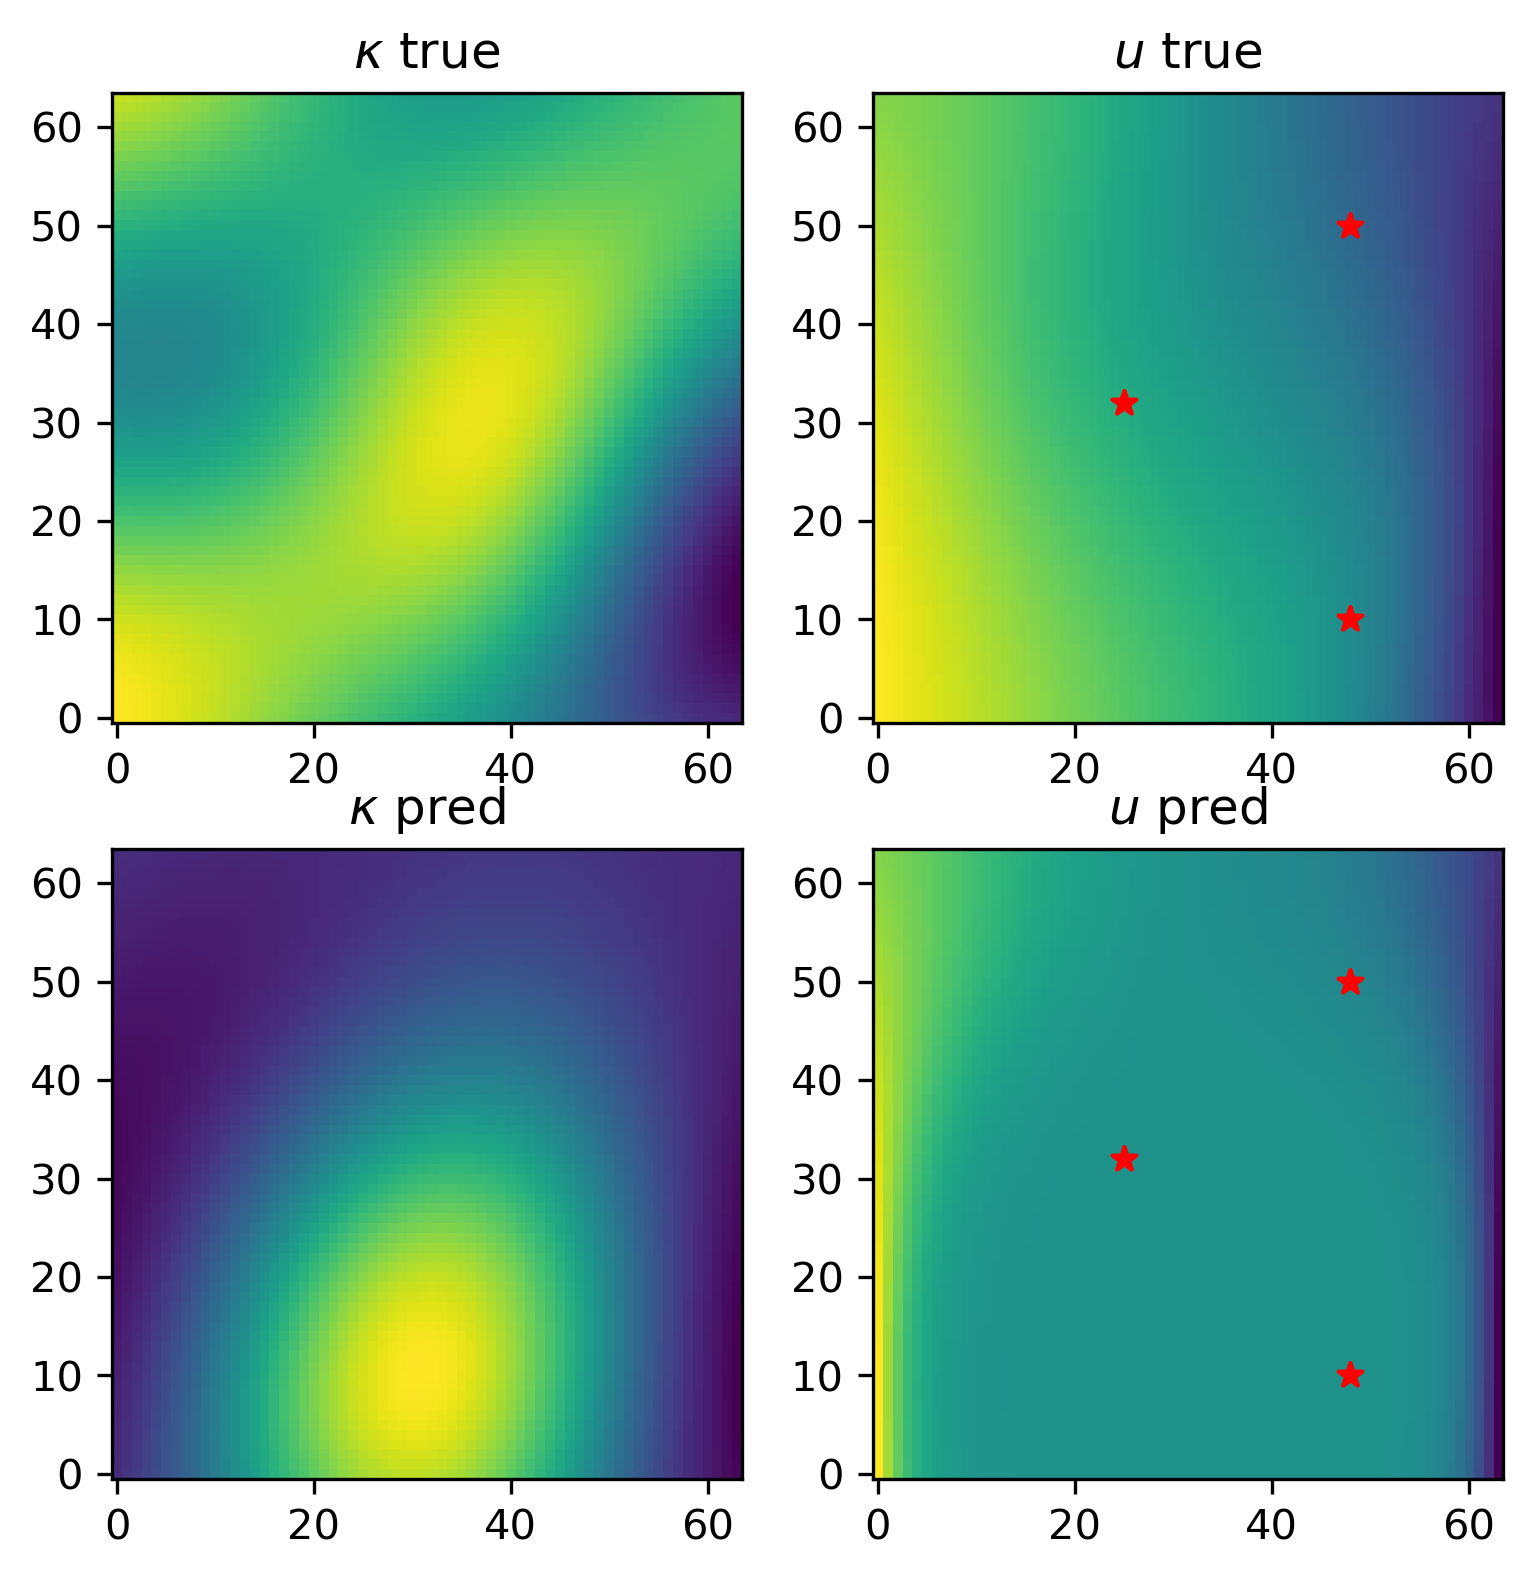

In [18]:
plt.figure(figsize=(6,6), dpi=300)
plt.subplot(221)
plt.imshow(log_kappa.T, cmap='viridis', origin='lower')
plt.title(fr'$\kappa$ true')
plt.subplot(222)
plt.imshow(u.T, cmap='viridis', origin='lower')
plt.scatter([x[1] for x in points], [x[0] for x in points], color='r', marker='*')
plt.title(fr'$u$ true')
plt.subplot(223)
plt.imshow(log_kappa_pred.T, cmap='viridis', origin='lower')
plt.title(fr'$\kappa$ pred')
plt.subplot(224)
plt.imshow(u_pred.T, cmap='viridis', origin='lower')
plt.scatter([x[1] for x in points], [x[0] for x in points], color='r', marker='*')
plt.title(fr'$u$ pred')
plt.savefig('imgs/pde_prediction_avg.png')
plt.show()

In [19]:
datadir = 'data/point3_100k'
soldir = f'{datadir}/sols'

In [24]:
!pip install natsort

/home/d_sherki/anaconda3/envs/py39/lib/python3.9/pty.py:85: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [25]:
from glob import glob
from natsort import natsorted

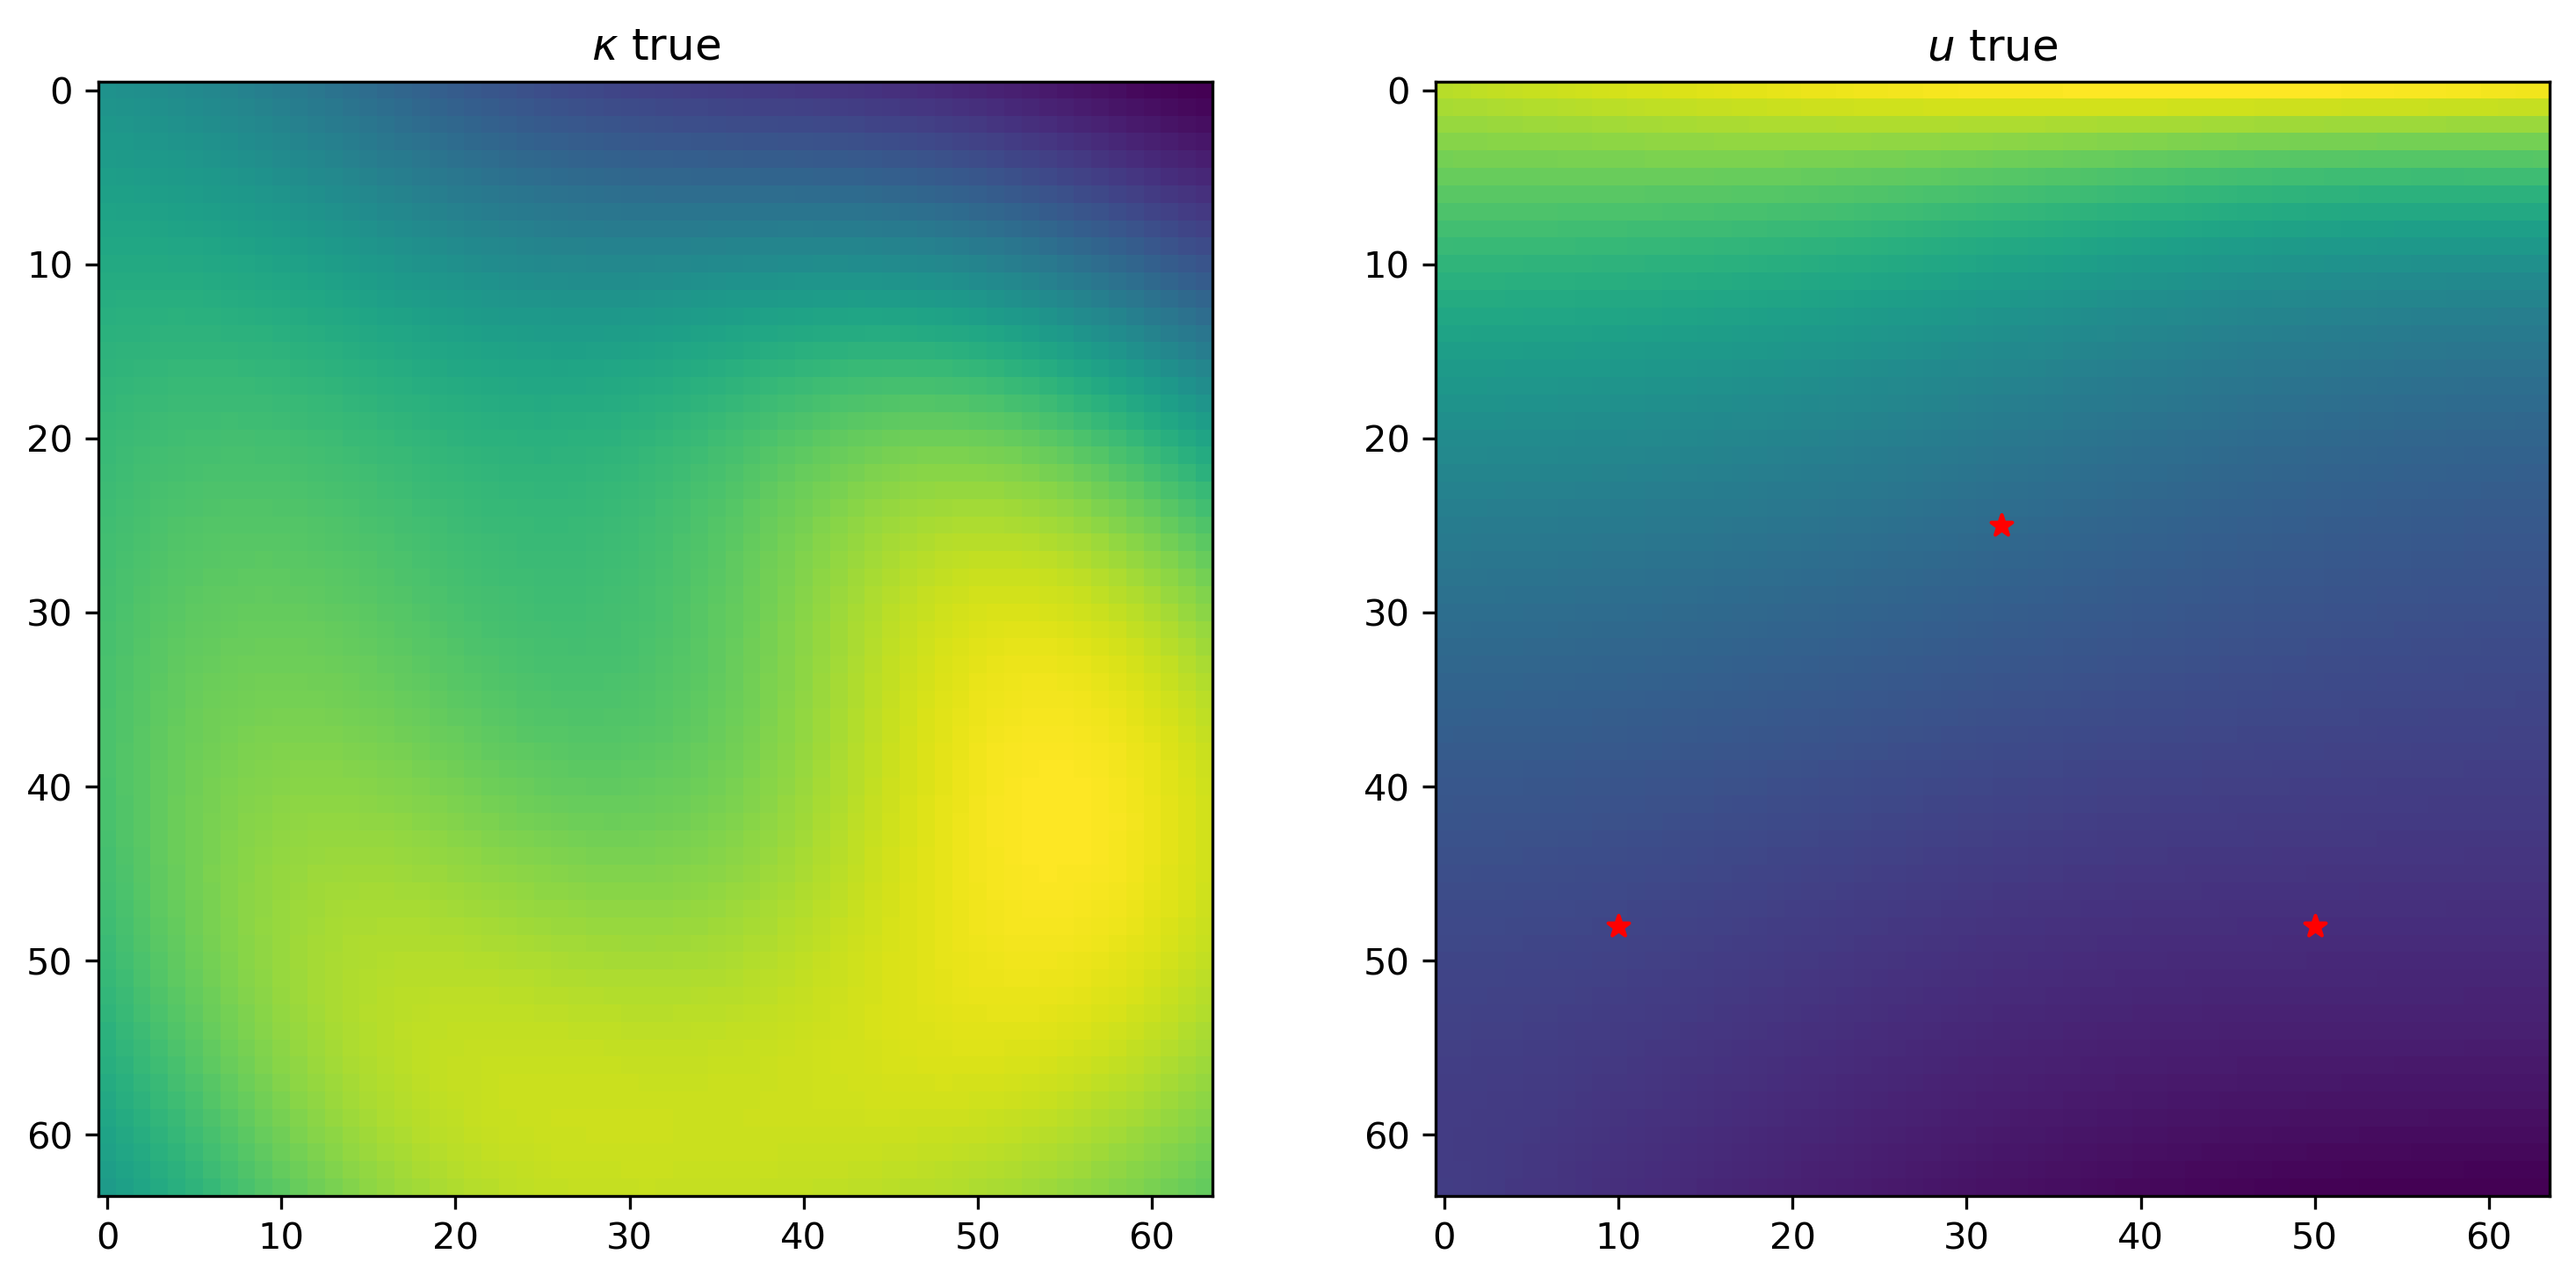

In [18]:
import numpy as np
from typing import List
from tqdm import tqdm
import os

from solver import pde_solution
from kl_extension import KLExpansion
from utils import get_d_from_u

points = [(50, 48), (32, 25), (10, 48)]

kl = KLExpansion(grid=(64, 64))
kl.calculate_eigh()

m = np.random.normal(size = 16)
e = np.random.uniform(size = 2)
log_kappa = kl.expansion(m)
u = pde_solution(log_kappa, e, verbose=False)
d = get_d_from_u(u, points)
m0 = np.random.normal(size=16)

plt.figure(figsize=(12,6), dpi=300)
plt.subplot(221)
plt.imshow(log_kappa, cmap='viridis', origin='upper')
plt.title(fr'$\kappa$ true')
plt.subplot(222)
plt.imshow(u, cmap='viridis', origin='upper')
plt.scatter([x[0] for x in points], [x[1] for x in points], color='r', marker='*')
plt.title(fr'$u$ true')
plt.show()
plt.figure(figsize=(12,6), dpi=300)
plt.subplot(223)
plt.imshow(log_kappa, cmap='viridis', origin='upper')
plt.title(fr'$\kappa$ true')
plt.subplot(224)
plt.imshow(u, cmap='viridis', origin='upper')
plt.scatter([x[0] for x in points], [x[1] for x in points], color='r', marker='*')
plt.title(fr'$u$ true')
plt.show()


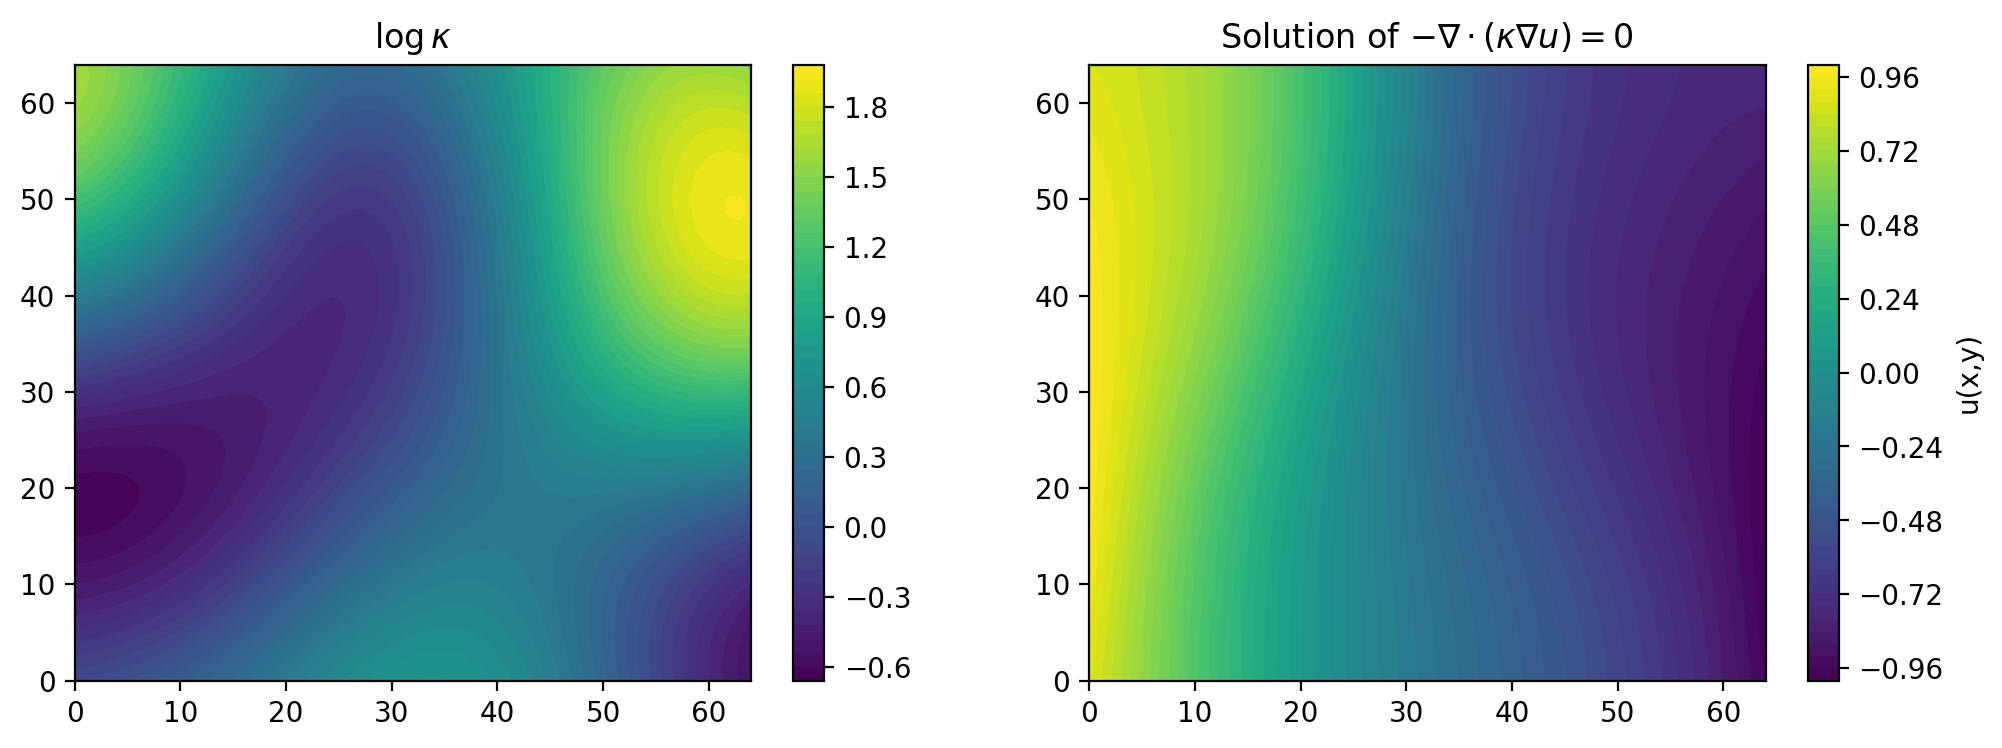

In [9]:
import numpy as np
from typing import List
from tqdm import tqdm
import os

from solver import pde_solution
from kl_extension import KLExpansion
from utils import get_d_from_u

points = [(48, 50), (25, 32), (48, 10)]

kl = KLExpansion(grid=(64, 64))
kl.calculate_eigh()

m = np.random.normal(size = 16)
e = np.random.uniform(size = 2)
log_kappa = kl.expansion(m)
u = pde_solution(log_kappa, e, verbose=False)
d = get_d_from_u(u, points)

plt.figure(figsize=(12, 4), dpi=200)
plt.subplot(121)
plt.contourf(kl.X_mesh*64, kl.Y_mesh*64, log_kappa.T, levels=50, cmap='viridis')
plt.colorbar()
plt.title(fr'$\log \kappa$')
plt.subplot(122)
plt.contourf(kl.X_mesh*64, kl.Y_mesh*64, u.T, levels=50, cmap='viridis')
plt.colorbar(label='u(x,y)')
plt.title(fr'Solution of $-\nabla \cdot (\kappa \nabla u) = 0$')
plt.show()